<h1><center><font size = 6>New York City Restaurant Exploring</center></h1>
<center>**Yao Long**</center>  
*This notebook will be mainly used for the capstone project of [Applied Data Science Specilization](https://www.coursera.org/specializations/applied-data-science)* 

## Introduction

In this project, we are going to explore the restaurants in the New York City. We will cluster its 306 neighborhoods into 5 groups based on the similarity of their restaurant category by using *k-means* clustering algorithm. We will also conduct a detailed analysis for the Chinese restaurants

In [51]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

#!pip install html5lib
import html5lib # library for reading tables from html
import json # library to handle JSON files

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

import matplotlib.pyplot as plt

# install wordcloud
#!pip install wordcloud

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

import statsmodels.api as sm

print ("Library Imported!")

Library Imported!


## 1. New York City Neighborhood Clustering

In this section, we will first build a dataframe of the New York City neighborhood data, which was downloaded from https://geo.nyu.edu/catalog/nyu_2451_34572. Then, we will use the Foursquare API to explore the restaurants of each neighborhood. Based on the restaurant information, we will implement the *k-means* clustering algorithm to divide the 306 neighborhoods into 5 clusters.

### 1.1 New York City neighborhood data

Read the downloaded New York City neighborhood json data

In [52]:
with open('nyu-geojson.json') as json_data:
    newyork_data = json.load(json_data)

Explore the dataset

In [53]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

Define a *pandas* dataframe

In [54]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Transform the data into the *pandas* dataframe

In [55]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Check the size and format of the dataframe

In [56]:
print(neighborhoods.shape)
neighborhoods.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Limited by the amount of information we can retrieve from Foursquare, lets limit our clustering scope to just Manhanttan

In [57]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Use geopy library to get the latitude and longitude values of Manhattan.

In [58]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


Create a map of Manhattan with neighborhoods superimposed on top

In [59]:
# create map of New York using latitude and longitude values
map_mh = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mh)  
    
map_mh

### 1.2 New York City restaurant data

Define Foursquare Credentials and Version

In [60]:
CLIENT_ID = 'HNFLZH3UWHFUDVB2RNIISYLL4D2S13BHKOPLQLDOQCXCUFC5' # your Foursquare ID
CLIENT_SECRET = '0P3W2D2DVKYMYAFYBJLIJQX0XGEXZ1JJDP31MS4F0LZV3ZHR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HNFLZH3UWHFUDVB2RNIISYLL4D2S13BHKOPLQLDOQCXCUFC5
CLIENT_SECRET:0P3W2D2DVKYMYAFYBJLIJQX0XGEXZ1JJDP31MS4F0LZV3ZHR


Create a function to get the top 100 restaurants in each neighborhood within a radius of 800 meters

In [61]:
def getNearbyVenues(names, latitudes, longitudes, radius=800, LIMIT=100, categoryId='4d4b7105d754a06374d81259'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):  
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [62]:
ny_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Check the size and format of the dataframe

In [63]:
print(ny_venues.shape)
ny_venues.head()

(3831, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
2,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Estrellita Poblana V,40.879687,-73.906257,Mexican Restaurant


Group the restaurants for each neighborhood

In [64]:
ny_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,100,100,100,100,100,100
Carnegie Hill,100,100,100,100,100,100
Central Harlem,92,92,92,92,92,92
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100


### 1.3 Neighborhoods clustering

Create a onehot dataframe for the restaurants

In [65]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

Check the size and format of the dataframe

In [66]:
print(ny_onehot.shape)
ny_onehot.head()

(3831, 127)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [67]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
print(ny_grouped.shape)
ny_grouped.head()

(40, 127)


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Battery Park City,0.0,0.000000,0.030000,0.00,0.00,0.00,0.00,0.00,0.020000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00,0.01
1,Carnegie Hill,0.0,0.000000,0.020000,0.00,0.01,0.01,0.00,0.01,0.000000,...,0.04,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.03,0.00
2,Central Harlem,0.0,0.054348,0.021739,0.00,0.00,0.00,0.00,0.00,0.032609,...,0.00,0.0,0.0,0.0,0.0,0.0,0.01087,0.0,0.00,0.00
3,Chelsea,0.0,0.000000,0.050000,0.01,0.00,0.01,0.00,0.00,0.000000,...,0.01,0.0,0.0,0.0,0.0,0.0,0.02000,0.0,0.03,0.00
4,Chinatown,0.0,0.000000,0.030000,0.00,0.00,0.02,0.01,0.01,0.000000,...,0.01,0.0,0.0,0.0,0.0,0.0,0.02000,0.0,0.06,0.00


Print the first 5 neighborhoods along with the top 5 most common restaurant categories

In [68]:
num_top_venues = 5

for hood in ny_grouped[:5]['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                venue  freq
0  Italian Restaurant  0.09
1         Pizza Place  0.08
2       Deli / Bodega  0.06
3          Steakhouse  0.06
4      Sandwich Place  0.06


----Carnegie Hill----
                venue  freq
0  Italian Restaurant  0.11
1         Pizza Place  0.10
2                Café  0.07
3  Mexican Restaurant  0.06
4              Bakery  0.05


----Central Harlem----
                             venue  freq
0                    Deli / Bodega  0.12
1              Fried Chicken Joint  0.10
2               Chinese Restaurant  0.08
3  Southern / Soul Food Restaurant  0.07
4                      Pizza Place  0.07


----Chelsea----
                venue  freq
0              Bakery  0.09
1  Italian Restaurant  0.06
2         Pizza Place  0.05
3  Seafood Restaurant  0.05
4   French Restaurant  0.05


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.15
1                 Bakery  0.07
2  Vietnamese Restaurant  0.06
3    Dumpling

Create a function to sort the venues in descending order

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 5 restaurant categories for each neighborhood

In [70]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_sorted = pd.DataFrame(columns=columns)
ny_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    ny_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

ny_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Italian Restaurant,Pizza Place,Sandwich Place,Steakhouse,Deli / Bodega
1,Carnegie Hill,Italian Restaurant,Pizza Place,Café,Mexican Restaurant,Bakery
2,Central Harlem,Deli / Bodega,Fried Chicken Joint,Chinese Restaurant,Pizza Place,Southern / Soul Food Restaurant
3,Chelsea,Bakery,Italian Restaurant,French Restaurant,American Restaurant,Pizza Place
4,Chinatown,Chinese Restaurant,Bakery,Vietnamese Restaurant,Dumpling Restaurant,Dim Sum Restaurant


Run *k*-means to cluster the neighborhood into 5 clusters

In [71]:
# set number of clusters
kclusters = 5

ny_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 0, 3, 2, 3, 1, 0, 3, 3])

Create a new dataframe that includes the cluster as well as the top 5 restaurant categories for each neighborhood

In [72]:
# add clustering labels
# ny_sorted.drop('Cluster Labels', axis=1, inplace=True)

ny_sorted.insert(0, 'Cluster Labels', np.int_(kmeans.labels_))

ny_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(ny_sorted.set_index('Neighborhood'), on='Neighborhood')
ny_merged = ny_merged.dropna(axis = 0, how ='any') 

ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,0,Sandwich Place,Pizza Place,Donut Shop,Mexican Restaurant,Spanish Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Bakery,Vietnamese Restaurant,Dumpling Restaurant,Dim Sum Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Deli / Bodega,Chinese Restaurant,Pizza Place,Mexican Restaurant,Latin American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,0,Pizza Place,Deli / Bodega,Mexican Restaurant,Spanish Restaurant,Latin American Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Deli / Bodega,Pizza Place,Chinese Restaurant,Mexican Restaurant,Sandwich Place


Visualize the resulting clusters

In [73]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine clusters

In [74]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Sandwich Place,Pizza Place,Donut Shop,Mexican Restaurant,Spanish Restaurant
2,Washington Heights,Deli / Bodega,Chinese Restaurant,Pizza Place,Mexican Restaurant,Latin American Restaurant
3,Inwood,Pizza Place,Deli / Bodega,Mexican Restaurant,Spanish Restaurant,Latin American Restaurant
4,Hamilton Heights,Deli / Bodega,Pizza Place,Chinese Restaurant,Mexican Restaurant,Sandwich Place
5,Manhattanville,Deli / Bodega,Chinese Restaurant,Italian Restaurant,Sandwich Place,Mexican Restaurant
6,Central Harlem,Deli / Bodega,Fried Chicken Joint,Chinese Restaurant,Pizza Place,Southern / Soul Food Restaurant
7,East Harlem,Deli / Bodega,Pizza Place,Mexican Restaurant,Bakery,Sandwich Place
11,Roosevelt Island,Deli / Bodega,Pizza Place,Japanese Restaurant,Sushi Restaurant,Sandwich Place
25,Manhattan Valley,Deli / Bodega,Pizza Place,Indian Restaurant,Chinese Restaurant,Mexican Restaurant
26,Morningside Heights,Deli / Bodega,Chinese Restaurant,Italian Restaurant,Pizza Place,Sandwich Place


## 2. New York City Chinese Restaurant Popularity Analysis

In this section, we will first build a dataframe of the New York City Chinese Restaurants data, which was obtained from Yelp database. We will use the review count as an indication of the restaurant popularity, and we will analyze whether the price, rating, location and name will influence the restaurant's popularity.

### 2.1 New York City Chinese restaurant data

Define Yelp API key

In [75]:
API_KEY = 'GgsS_Bi5FmXk8Q8lU6QAULVW_o44JplnEhHezxVWhAUNXrV0JohX3h3JQrZIU1Lq5FVaB8Zbd63n2aX5nVuKxp1nUI7VOi0FoMF4zA2z6-T3_nVxoH9wE3ixOzQ-XXYx'

Retrieve the restaurant data from Yelp database

In [76]:
# see api reference: https://www.yelp.com/developers/documentation/v3/business_search
def get_data(num_rows=1000):
    limit = 50
    url_params = {
        'term': 'chinese',
        'location': 'Manhattan', 
        'limit': limit,
        'offset': 0
    }
    headers = {
        'Authorization': 'Bearer %s' % API_KEY,
    }
    
    df = pd.DataFrame()
    
    num_requests = int(num_rows / limit)
    for i in range(num_requests):
        print(u'Querying ...')
        response = requests.request('GET', 'https://api.yelp.com/v3/businesses/search', headers=headers, params=url_params)
        new_df = pd.DataFrame(response.json()['businesses'])
        df = pd.concat([df, new_df])
        
        url_params['offset'] += limit
    
    return df

In [77]:
data = get_data()

Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...
Querying ...


Check data size and format

In [78]:
print(data.shape)
data.head()

(1000, 16)


,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,café-china-new-york-2,"[{'alias': 'szechuan', 'title': 'Szechuan'}]","{'latitude': 40.7499225208569, 'longitude': -7...",(212) 213-2810,1180.695648,xq0cX_DgxiJMXwhmEl9kUA,https://s3-media1.fl.yelpcdn.com/bphoto/UhHqxE...,False,"{'address1': '13 E 37th St', 'address2': None,...",Café China,+12122132810,$$,4.0,1501,"[pickup, delivery, restaurant_reservation]",https://www.yelp.com/biz/caf%C3%A9-china-new-y...
1,the-tang-upper-west-side-new-york,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...","{'latitude': 40.80006, 'longitude': -73.96639}",(646) 596-7970,4538.220225,TzhAlljC_843JO7UDDUIaQ,https://s3-media3.fl.yelpcdn.com/bphoto/uNjNuc...,False,"{'address1': '920 Amsterdam Ave', 'address2': ...",The Tang - Upper West Side,+16465967970,$$,4.5,78,"[delivery, pickup, restaurant_reservation]",https://www.yelp.com/biz/the-tang-upper-west-s...
2,tri-dim-shanghai-new-york-2,"[{'alias': 'shanghainese', 'title': 'Shanghain...","{'latitude': 40.77395, 'longitude': -73.95793}",(212) 585-3388,2311.776215,oowNI_aUmGEFa_VW8BFgRg,https://s3-media1.fl.yelpcdn.com/bphoto/-HycyO...,False,"{'address1': '1378 3rd Ave', 'address2': '', '...",Tri Dim Shanghai,+12125853388,$$,4.0,316,"[pickup, delivery, restaurant_reservation]",https://www.yelp.com/biz/tri-dim-shanghai-new-...
3,chow-house-new-york,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...","{'latitude': 40.72915, 'longitude': -74.00072}",(212) 837-1021,3928.816913,0dDCDQz7DrKkSvu9h2hcQw,https://s3-media3.fl.yelpcdn.com/bphoto/kzeCls...,False,"{'address1': '181 Bleecker St', 'address2': No...",Chow House,+12128371021,$$,4.5,296,"[delivery, pickup, restaurant_reservation]",https://www.yelp.com/biz/chow-house-new-york?a...
4,han-dynasty-new-york,"[{'alias': 'szechuan', 'title': 'Szechuan'}, {...","{'latitude': 40.732072, 'longitude': -73.988074}",(212) 390-8685,3231.601933,wfhMIiMh2A2psCGONOVSlg,https://s3-media2.fl.yelpcdn.com/bphoto/0yQ7sA...,False,"{'address1': '90 3rd Ave', 'address2': '', 'ad...",Han Dynasty,+12123908685,$$,4.0,1170,"[delivery, pickup, restaurant_reservation]",https://www.yelp.com/biz/han-dynasty-new-york?...


Clean the obtained data and build the Chinese restaurant dataframe

In [79]:
cr_data = data[['name', 'price', 'rating', 'review_count', 'coordinates']]
cr_data = pd.concat([cr_data.drop(['coordinates'], axis=1), cr_data['coordinates'].apply(pd.Series)], axis=1)
cr_data.dropna(subset=['price'], how='all', inplace = True)
cr_data['price'] = cr_data['price'].apply(lambda x: len(x))
cr_data.head()

,name,price,rating,review_count,latitude,longitude
0,Café China,2,4.0,1501,40.749923,-73.981946
1,The Tang - Upper West Side,2,4.5,78,40.800060,-73.966390
2,Tri Dim Shanghai,2,4.0,316,40.773950,-73.957930
3,Chow House,2,4.5,296,40.729150,-74.000720
4,Han Dynasty,2,4.0,1170,40.732072,-73.988074


### 2.2 Chinese restaurant popularity analysis

Visualize the statistical characteristics of the review counts

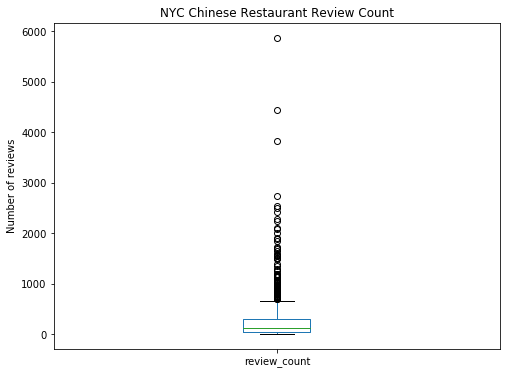

,review_count
count,861.000000
mean,275.397213
std,464.895020
min,1.000000
25%,44.000000
50%,122.000000
75%,291.000000
max,5873.000000


In [80]:
cr_data[['review_count']].plot(kind='box', figsize=(8, 6))
plt.title('NYC Chinese Restaurant Review Count')
plt.ylabel('Number of reviews')
plt.show()
cr_data[['review_count']].describe()

Show the most popular Chinese Restaurants

In [81]:
print('The most popular Chinese restaurtants are:')
cr_data.sort_values(by='review_count', ascending=False).head()

The most popular Chinese restaurtants are:


,name,price,rating,review_count,latitude,longitude
34,Joe's Shanghai,2,4.0,5873,40.714669,-73.997760
36,LoveMama,2,4.5,4442,40.730386,-73.986061
46,Buddakan,3,4.0,3818,40.742276,-74.004800
7,Thai Villa,2,4.5,2744,40.739020,-73.990650
49,Vanessa's Dumpling House,1,4.0,2535,40.718390,-73.991740


#### 2.2.1 Will the price or rating influence the popularity?

Conduct linear regression analysis for the popularity and price

In [82]:
X = cr_data[['price']]
y = cr_data['review_count']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_count   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     380.3
Date:                Sat, 10 Aug 2019   Prob (F-statistic):           2.00e-70
Time:                        11:36:54   Log-Likelihood:                -6481.3
No. Observations:                 861   AIC:                         1.296e+04
Df Residuals:                     860   BIC:                         1.297e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
price        170.9014      8.763     19.502      0.000       153.702   188.101
==============================================================================
Omnibus:                      932.519   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66096.957
Skew:                           5.152   Prob(JB):                         0.00
Kurtosis:                      44.669   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conduct linear regression analysis for the popularity and rating

In [83]:
X = cr_data[['rating']]
y = cr_data['review_count']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_count   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     314.9
Date:                Sat, 10 Aug 2019   Prob (F-statistic):           2.86e-60
Time:                        11:36:56   Log-Likelihood:                -6504.6
No. Observations:                 861   AIC:                         1.301e+04
Df Residuals:                     860   BIC:                         1.302e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
rating        74.4999      4.198     17.745      0.000        66.260    82.740
==============================================================================
Omnibus:                      908.429   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57960.031
Skew:                           4.966   Prob(JB):                         0.00
Kurtosis:                      41.948   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 2.2.2 Will the location influence the popularity?

Obtain the coordinated of New York City

In [84]:
address = 'New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


Create a map of New York City with the hottest Chinese restaurants superimposed on top

In [85]:
map_hottest = folium.Map(location=[latitude, longitude], zoom_start=12)
restaurants = folium.map.FeatureGroup()
cr_popularity = cr_data.sort_values(by='review_count', ascending=False).head(50)
for lat, lng, in zip(cr_popularity['latitude'], cr_popularity['longitude']):
    restaurants.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=1
        )
    )

map_hottest.add_child(restaurants)

#### 2.2.3 Will the name influence the popularity?

Collect the names for the top 250 restaurants and the bottom 250 restaurants

In [86]:
top_data = cr_data.sort_values(by='review_count', ascending=False).head(250)
names_top = ''
for name in top_data['name']:
    names_top += name + ' '
bottom_data = cr_data.sort_values(by='review_count', ascending=True).head(250)
names_bottom = ''
for name in bottom_data['name']:
    names_bottom += name + ' '

Create a word cloud object and generate a word cloud for the names of the top 250 restaurants and the bottom 250 restaurants

In [87]:
stopwords = set(STOPWORDS)
stopwords.add('restaurant')

In [88]:
# instantiate a word cloud object
top_names = WordCloud(
    background_color='white',
    stopwords=stopwords
)

# generate the word cloud
top_names.generate(names_top)

# instantiate a word cloud object
bottom_names = WordCloud(
    background_color='white',
    stopwords=stopwords
)

# generate the word cloud
bottom_names.generate(names_bottom)

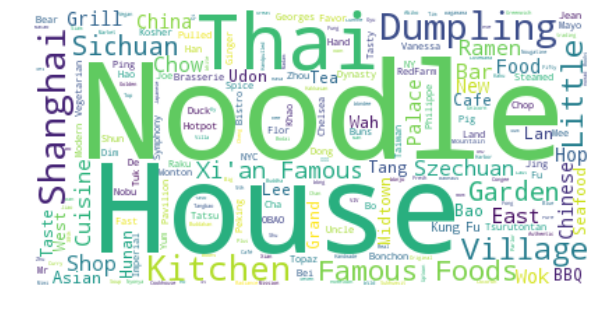

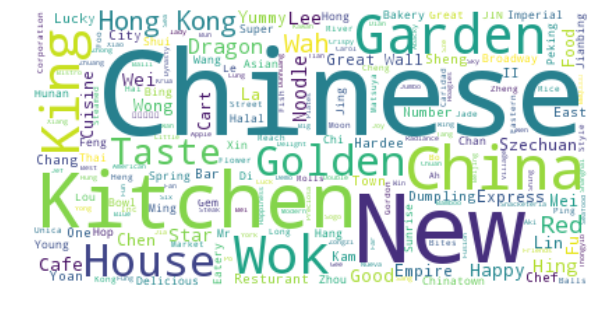

In [45]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(12) # set height
plt.imshow(top_names, interpolation='bilinear')
plt.axis('off')
plt.show()

fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(12) # set height
plt.imshow(bottom_names, interpolation='bilinear')
plt.axis('off')
plt.show()